<a href="https://colab.research.google.com/github/CGSData/Proyecto_DSII/blob/main/ProyectoDSII_GonzalezCarlos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Industria de Videojuegos

# Introducción

En la industria de los videojuegos, comprender los factores que influyen en el éxito de un juego es de vital importancia. Miles de títulos son lanzados cada año, y las preferencias de los jugadores pueden cambiar rápidamente. Por esto, son necesarios insights basados en datos para tomar decisiones informadas que maximicen las oportunidades de éxito y rentabilidad.

El análisis se centra en un dataframe que contiene información detallada sobre una colección de juegos. Este dataset permite explorar diversas características que podrían influir en la popularidad y el rendimiento de un juego.

# Preguntas de Interés

* Que géneros son los mas populares?
* Cómo afecta el numero de jugadas al rating?
* Cuál es el impacto de las reseñas en la popularidad de un juego?
* Que equipo de desarrollo tiene los juegos con mayores rating?

# Librerias


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
import plotly.express as px
import ast
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold, cross_val_score
from sklearn.model_selection import RandomizedSearchCV

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [2]:
!pip install lazypredict

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.9/190.9 MB 4.0 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.3.1+cu121 requires nvidia-cublas-cu12==12.1.3.1; platform_system == "Linux" and platform_machine == "x86_64", which is not installed.
torch 2.3.1+cu121 requires nvidia-cuda-cupti-cu12==12.1.105; platform_system == "Linux" and platform_machine == "x86_64", which is not installed.
torch 2.3.1+cu121 requires nvidia-cuda-nvrtc-cu12==12.1.105; platform_system == "Linux" and platform_machine == "x86_64", which is not installed.
torch 2.3.1+cu121 requires nvidia-cuda-runtime-cu12==12.1.105; platform_system == "Linux" and platform_machine == "x86_64", which is not installed.
torch 2.3.1+cu121 requires nvidia-cudnn-cu12==8.9.2.26; platform_system == "Linux" and platform_machine == "x86_64", which is not installed.
torch 2.3.1+cu121 requ

# Dataset

In [3]:
URL = 'https://raw.githubusercontent.com/CGSData/Games/6682410a1ed4c58793be46904be4580343e23a82/games.csv'
df_games = pd.read_csv(URL)
df_games.head()

,Unnamed: 0,Title,Release Date,Team,Rating,Times Listed,Number of Reviews,Genres,Summary,Reviews,Plays,Playing,Backlogs,Wishlist
0,0,Elden Ring,"Feb 25, 2022","['Bandai Namco Entertainment', 'FromSoftware']",4.5,3.9K,3.9K,"['Adventure', 'RPG']","Elden Ring is a fantasy, action and open world...","[""The first playthrough of elden ring is one o...",17K,3.8K,4.6K,4.8K
1,1,Hades,"Dec 10, 2019",['Supergiant Games'],4.3,2.9K,2.9K,"['Adventure', 'Brawler', 'Indie', 'RPG']",A rogue-lite hack and slash dungeon crawler in...,['convinced this is a roguelike for people who...,21K,3.2K,6.3K,3.6K
2,2,The Legend of Zelda: Breath of the Wild,"Mar 03, 2017","['Nintendo', 'Nintendo EPD Production Group No...",4.4,4.3K,4.3K,"['Adventure', 'RPG']",The Legend of Zelda: Breath of the Wild is the...,['This game is the game (that is not CS:GO) th...,30K,2.5K,5K,2.6K
3,3,Undertale,"Sep 15, 2015","['tobyfox', '8-4']",4.2,3.5K,3.5K,"['Adventure', 'Indie', 'RPG', 'Turn Based Stra...","A small child falls into the Underground, wher...",['soundtrack is tied for #1 with nier automata...,28K,679,4.9K,1.8K
4,4,Hollow Knight,"Feb 24, 2017",['Team Cherry'],4.4,3K,3K,"['Adventure', 'Indie', 'Platform']",A 2D metroidvania with an emphasis on close co...,"[""this games worldbuilding is incredible, with...",21K,2.4K,8.3K,2.3K


En el dataset importado se tienen las siguientes columnas:
* Title: Corresponde al titulo de cada juego, se incluyen DLC y versiones diferentes del mismo juego.
* Release Date: Fecha de lanzamiento.
* Team: Equipo de desarrollo.
* Rating: Puntaje otorgado por los jugadores.
* Times Listed: Número de usuarios que agregaron el juego a su lista.
* Number of Reviews: Número de reseñas.
* Genres: Generos.
* Summary: Resumen de lo que trata el juego.
* Reviews: Algunas reseñas dadas por los usuarios.
* Plays: Número de veces que se ha jugado ese juego.
* Playing: Número de jugadores activos al momento de obtener los datos.
* Backlogs: Número de usuarios que tienen el juego pero aún no lo inician.
* Wishlist: Número de usuarios que agregaron el juego a lista de deseados.



In [4]:
print(df_games.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1512 entries, 0 to 1511
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Unnamed: 0         1512 non-null   int64  
 1   Title              1512 non-null   object 
 2   Release Date       1512 non-null   object 
 3   Team               1511 non-null   object 
 4   Rating             1499 non-null   float64
 5   Times Listed       1512 non-null   object 
 6   Number of Reviews  1512 non-null   object 
 7   Genres             1512 non-null   object 
 8   Summary            1511 non-null   object 
 9   Reviews            1512 non-null   object 
 10  Plays              1512 non-null   object 
 11  Playing            1512 non-null   object 
 12  Backlogs           1512 non-null   object 
 13  Wishlist           1512 non-null   object 
dtypes: float64(1), int64(1), object(12)
memory usage: 165.5+ KB
None


In [5]:
df_games.shape

(1512, 14)

# Data Wrangling

### Se define un nuevo dataframe usando solo las columnas utiles

Se consideran solo las columnas que aportan a la exploración de datos. Se eliminan las columnas 'Times listed', 'Summary', 'Reviews', 'Playing' y 'Backlogs'

In [6]:
col_estudio = ['Title', 'Release Date', 'Team', 'Rating', 'Number of Reviews', 'Genres', 'Plays', 'Wishlist']
df = df_games[col_estudio].reset_index(drop=True)
df


,Title,Release Date,Team,Rating,Number of Reviews,Genres,Plays,Wishlist
0,Elden Ring,"Feb 25, 2022","['Bandai Namco Entertainment', 'FromSoftware']",4.5,3.9K,"['Adventure', 'RPG']",17K,4.8K
1,Hades,"Dec 10, 2019",['Supergiant Games'],4.3,2.9K,"['Adventure', 'Brawler', 'Indie', 'RPG']",21K,3.6K
2,The Legend of Zelda: Breath of the Wild,"Mar 03, 2017","['Nintendo', 'Nintendo EPD Production Group No...",4.4,4.3K,"['Adventure', 'RPG']",30K,2.6K
3,Undertale,"Sep 15, 2015","['tobyfox', '8-4']",4.2,3.5K,"['Adventure', 'Indie', 'RPG', 'Turn Based Stra...",28K,1.8K
4,Hollow Knight,"Feb 24, 2017",['Team Cherry'],4.4,3K,"['Adventure', 'Indie', 'Platform']",21K,2.3K
...,...,...,...,...,...,...,...,...
1507,Back to the Future: The Game,"Dec 22, 2010",['Telltale Games'],3.2,94,"['Adventure', 'Point-and-Click']",763,67
1508,Team Sonic Racing,"May 21, 2019","['Sumo Digital', 'Sega']",2.9,264,"['Arcade', 'Racing']",1.5K,107
1509,Dragon's Dogma,"May 22, 2012",['Capcom'],3.7,210,"['Brawler', 'RPG']",1.1K,206
1510,Baldur's Gate 3,"Oct 06, 2020",['Larian Studios'],4.1,165,"['Adventure', 'RPG', 'Strategy', 'Tactical', '...",269,602


In [7]:
# Se renombran las columnas 'Release Data' y 'Number of Reviews' por 'Release' y 'Reviews' respectivamente
df.rename(columns={'Release Date': 'Release', 'Number of Reviews': 'Reviews'}, inplace=True)

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1512 entries, 0 to 1511
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Title     1512 non-null   object 
 1   Release   1512 non-null   object 
 2   Team      1511 non-null   object 
 3   Rating    1499 non-null   float64
 4   Reviews   1512 non-null   object 
 5   Genres    1512 non-null   object 
 6   Plays     1512 non-null   object 
 7   Wishlist  1512 non-null   object 
dtypes: float64(1), object(7)
memory usage: 94.6+ KB


### Procesamiento de datos

In [9]:
# Se reemplaza la K en los datos y se pasa a tipo numerico
df['Reviews'] = df['Reviews'].str.replace('K', '000').str.replace('.', '').astype(int)
df['Plays'] = df['Plays'].str.replace('K', '000').str.replace('.', '').astype(int)
df['Wishlist'] = df['Wishlist'].str.replace('K', '000').str.replace('.', '').astype(int)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1512 entries, 0 to 1511
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Title     1512 non-null   object 
 1   Release   1512 non-null   object 
 2   Team      1511 non-null   object 
 3   Rating    1499 non-null   float64
 4   Reviews   1512 non-null   int64  
 5   Genres    1512 non-null   object 
 6   Plays     1512 non-null   int64  
 7   Wishlist  1512 non-null   int64  
dtypes: float64(1), int64(3), object(4)
memory usage: 94.6+ KB


In [10]:
df.head()

,Title,Release,Team,Rating,Reviews,Genres,Plays,Wishlist
0,Elden Ring,"Feb 25, 2022","['Bandai Namco Entertainment', 'FromSoftware']",4.5,39000,"['Adventure', 'RPG']",17000,48000
1,Hades,"Dec 10, 2019",['Supergiant Games'],4.3,29000,"['Adventure', 'Brawler', 'Indie', 'RPG']",21000,36000
2,The Legend of Zelda: Breath of the Wild,"Mar 03, 2017","['Nintendo', 'Nintendo EPD Production Group No...",4.4,43000,"['Adventure', 'RPG']",30000,26000
3,Undertale,"Sep 15, 2015","['tobyfox', '8-4']",4.2,35000,"['Adventure', 'Indie', 'RPG', 'Turn Based Stra...",28000,18000
4,Hollow Knight,"Feb 24, 2017",['Team Cherry'],4.4,3000,"['Adventure', 'Indie', 'Platform']",21000,23000


In [11]:
# Se revisa si existen datos = 0 en las columnas numericas
print("Rating: ",df[(df.Rating == 0)].shape[0])
print("Reviews: ",df[(df['Reviews'] == 0)].shape[0])
print("Plays: ",df[(df.Plays == 0)].shape[0])
print("Wishlist: ",df[(df.Wishlist == 0)].shape[0])


Rating:  0
Reviews:  1
Plays:  1
Wishlist:  0


In [12]:
# Se borran los datos = 0, debido a que no tiene sentido tener estos valores
df.drop(df[(df['Reviews']==0)].index, inplace=True)
df.drop(df[(df.Plays==0)].index, inplace=True)
df.reset_index(drop=True, inplace=True)
df

,Title,Release,Team,Rating,Reviews,Genres,Plays,Wishlist
0,Elden Ring,"Feb 25, 2022","['Bandai Namco Entertainment', 'FromSoftware']",4.5,39000,"['Adventure', 'RPG']",17000,48000
1,Hades,"Dec 10, 2019",['Supergiant Games'],4.3,29000,"['Adventure', 'Brawler', 'Indie', 'RPG']",21000,36000
2,The Legend of Zelda: Breath of the Wild,"Mar 03, 2017","['Nintendo', 'Nintendo EPD Production Group No...",4.4,43000,"['Adventure', 'RPG']",30000,26000
3,Undertale,"Sep 15, 2015","['tobyfox', '8-4']",4.2,35000,"['Adventure', 'Indie', 'RPG', 'Turn Based Stra...",28000,18000
4,Hollow Knight,"Feb 24, 2017",['Team Cherry'],4.4,3000,"['Adventure', 'Indie', 'Platform']",21000,23000
...,...,...,...,...,...,...,...,...
1505,Back to the Future: The Game,"Dec 22, 2010",['Telltale Games'],3.2,94,"['Adventure', 'Point-and-Click']",763,67
1506,Team Sonic Racing,"May 21, 2019","['Sumo Digital', 'Sega']",2.9,264,"['Arcade', 'Racing']",15000,107
1507,Dragon's Dogma,"May 22, 2012",['Capcom'],3.7,210,"['Brawler', 'RPG']",11000,206
1508,Baldur's Gate 3,"Oct 06, 2020",['Larian Studios'],4.1,165,"['Adventure', 'RPG', 'Strategy', 'Tactical', '...",269,602


### Tratamiento de nulos

In [13]:
# Se ve la cantidad de nulos en cada columna del nuevo df
nulos = pd.DataFrame({'Cantidad de nulos' : df.isnull().sum(),
                      'Porcentaje' : (df.isnull().sum()) / (len(df)) * (100)})
nulos

,Cantidad de nulos,Porcentaje
Title,0,0.000000
Release,0,0.000000
Team,1,0.066225
Rating,11,0.728477
Reviews,0,0.000000
Genres,0,0.000000
Plays,0,0.000000
Wishlist,0,0.000000


In [14]:
# Al ser porcentajes bajos menores al 1% se eliminar estos datos
df.dropna(inplace=True)
df.reset_index(drop=True, inplace=True)

In [15]:
# Ahora se revisa como quedó el Dataframe
nulos = pd.DataFrame({'Cantidad de nulos' : df.isnull().sum(),
                      'Porcentaje' : (df.isnull().sum()) / (len(df)) * (100)})
print(nulos, "\n", "\n", "El total de nulos en el Dataframe es:", nulos["Cantidad de nulos"].sum())

          Cantidad de nulos  Porcentaje
Title                     0         0.0
Release                   0         0.0
Team                      0         0.0
Rating                    0         0.0
Reviews                   0         0.0
Genres                    0         0.0
Plays                     0         0.0
Wishlist                  0         0.0 
 
 El total de nulos en el Dataframe es: 0


In [16]:
df

,Title,Release,Team,Rating,Reviews,Genres,Plays,Wishlist
0,Elden Ring,"Feb 25, 2022","['Bandai Namco Entertainment', 'FromSoftware']",4.5,39000,"['Adventure', 'RPG']",17000,48000
1,Hades,"Dec 10, 2019",['Supergiant Games'],4.3,29000,"['Adventure', 'Brawler', 'Indie', 'RPG']",21000,36000
2,The Legend of Zelda: Breath of the Wild,"Mar 03, 2017","['Nintendo', 'Nintendo EPD Production Group No...",4.4,43000,"['Adventure', 'RPG']",30000,26000
3,Undertale,"Sep 15, 2015","['tobyfox', '8-4']",4.2,35000,"['Adventure', 'Indie', 'RPG', 'Turn Based Stra...",28000,18000
4,Hollow Knight,"Feb 24, 2017",['Team Cherry'],4.4,3000,"['Adventure', 'Indie', 'Platform']",21000,23000
...,...,...,...,...,...,...,...,...
1493,Back to the Future: The Game,"Dec 22, 2010",['Telltale Games'],3.2,94,"['Adventure', 'Point-and-Click']",763,67
1494,Team Sonic Racing,"May 21, 2019","['Sumo Digital', 'Sega']",2.9,264,"['Arcade', 'Racing']",15000,107
1495,Dragon's Dogma,"May 22, 2012",['Capcom'],3.7,210,"['Brawler', 'RPG']",11000,206
1496,Baldur's Gate 3,"Oct 06, 2020",['Larian Studios'],4.1,165,"['Adventure', 'RPG', 'Strategy', 'Tactical', '...",269,602


In [17]:
# Se limita la columna 'Genres' para que solo muestre los 2 primeros generos en cada videojuego
def get_first_two_genres(genres_str):
    genres_list = ast.literal_eval(genres_str)
    first_two_genres = genres_list[:2]
    return ', '.join(first_two_genres)

df['Genres'] = df['Genres'].apply(get_first_two_genres)

df.head()

,Title,Release,Team,Rating,Reviews,Genres,Plays,Wishlist
0,Elden Ring,"Feb 25, 2022","['Bandai Namco Entertainment', 'FromSoftware']",4.5,39000,"Adventure, RPG",17000,48000
1,Hades,"Dec 10, 2019",['Supergiant Games'],4.3,29000,"Adventure, Brawler",21000,36000
2,The Legend of Zelda: Breath of the Wild,"Mar 03, 2017","['Nintendo', 'Nintendo EPD Production Group No...",4.4,43000,"Adventure, RPG",30000,26000
3,Undertale,"Sep 15, 2015","['tobyfox', '8-4']",4.2,35000,"Adventure, Indie",28000,18000
4,Hollow Knight,"Feb 24, 2017",['Team Cherry'],4.4,3000,"Adventure, Indie",21000,23000


# EDA

Primero se observan las estadísticas descriptivas para las variables numéricas

In [ ]:
numeric_columns = ['Rating', 'Reviews', 'Plays', 'Wishlist']
print("Estadísticas descriptivas para variables numéricas:")
print(df[numeric_columns].describe().T)


Estadísticas descriptivas para variables numéricas:
           count          mean           std  min       25%      50%      75%  \
Rating    1498.0      3.720027      0.532133  0.7      3.40      3.8      4.1   
Reviews   1498.0   4391.979306   7859.406039  8.0    294.25    555.0   1000.0   
Plays     1498.0  30493.476636  26256.383358  1.0  12000.00  21000.0  45000.0   
Wishlist  1498.0   4840.200935   8711.955868  2.0    212.00    496.0   2000.0   

              max  
Rating        4.8  
Reviews   43000.0  
Plays     99000.0  
Wishlist  48000.0  


Luego, se observa la frecuencia para los generos en la columnas 'Genres'

In [ ]:
categorical_columns = ['Genres']
print("\nFrecuencia de cada categoría para variables categóricas:")
for col in categorical_columns:
    print(df[col].value_counts())


Frecuencia de cada categoría para variables categóricas:
Genres
Adventure, RPG                 269
Adventure, Platform            177
Adventure, Indie               170
Adventure, Brawler             113
Adventure, Shooter              95
                              ... 
Music, Platform                  1
Card & Board Game, Platform      1
Music, Simulator                 1
Visual Novel                     1
Fighting, Sport                  1
Name: count, Length: 91, dtype: int64


Se crean gráficos de para observar mejor el comportamiento de los datos y responder las preguntas de interes.

Text(0.5, 1.0, 'Rating Distribution')

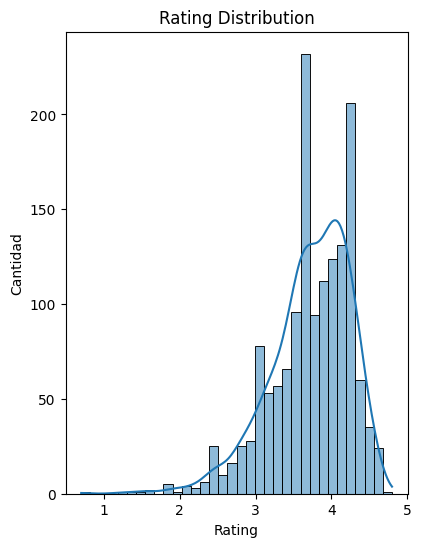

In [ ]:
# Visualización de datos para variable 'Rating'
plt.figure(figsize=(15, 6))
plt.subplot(1, 3, 1)
sns.histplot(df['Rating'], kde=True)
plt.ylabel('Cantidad')
plt.title('Rating Distribution')

Del gráfico 'Rating Distribution' se puede ver la cantidad de votos existentes en cada rating de los juegos estudiados, siendo la mayor concentración entre los rating de 3 a 5 y la mayor cantidad de votos se encuentran en el rating de 3.5 aproximadamente.

<ipython-input-21-b98211c36f70>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, y='Genres', palette='bright', order=df['Genres'].value_counts().index[:10])


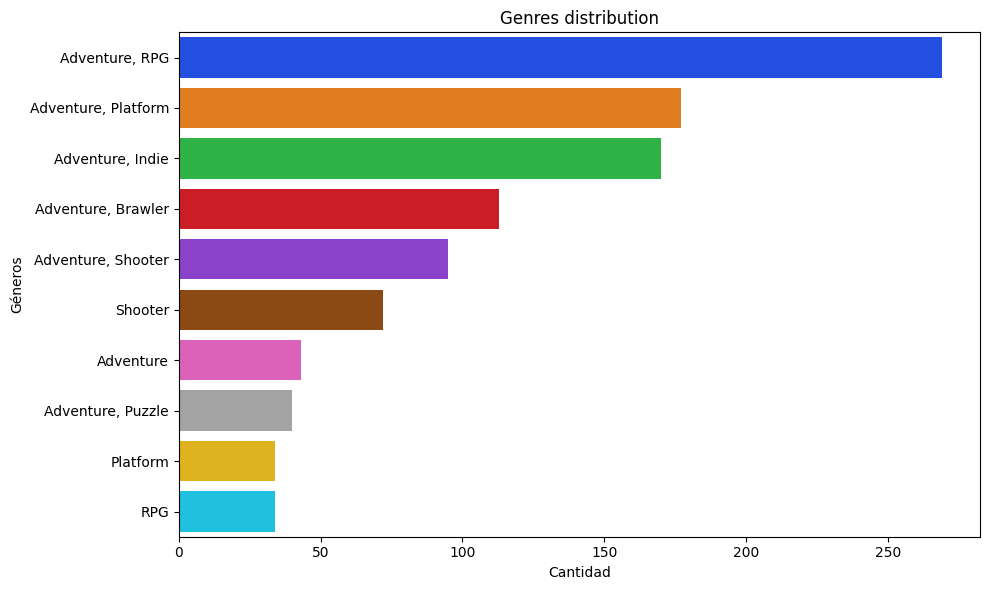

In [ ]:
# Visualizacion de datos para distribución de géneros de juegos
plt.figure(figsize=(10, 6))
sns.countplot(data=df, y='Genres', palette='bright', order=df['Genres'].value_counts().index[:10])
plt.title('Genres distribution')
plt.xlabel('Cantidad')
plt.ylabel('Géneros')
plt.tight_layout()
plt.show()

Del gráfico 'Genres distribution' Se puede ver la cantidad de juegos para cada genero existentes en el dataset, donde la mayor cantidad se encuentran en la categoria 'aventura'.

<ipython-input-22-f37d11b84593>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Plays', y='Genres', data=top_10_genres,palette=sns.color_palette("crest"))
<ipython-input-22-f37d11b84593>:7: UserWarning: 
The palette list has fewer values (6) than needed (10) and will cycle, which may produce an uninterpretable plot.
  sns.barplot(x='Plays', y='Genres', data=top_10_genres,palette=sns.color_palette("crest"))


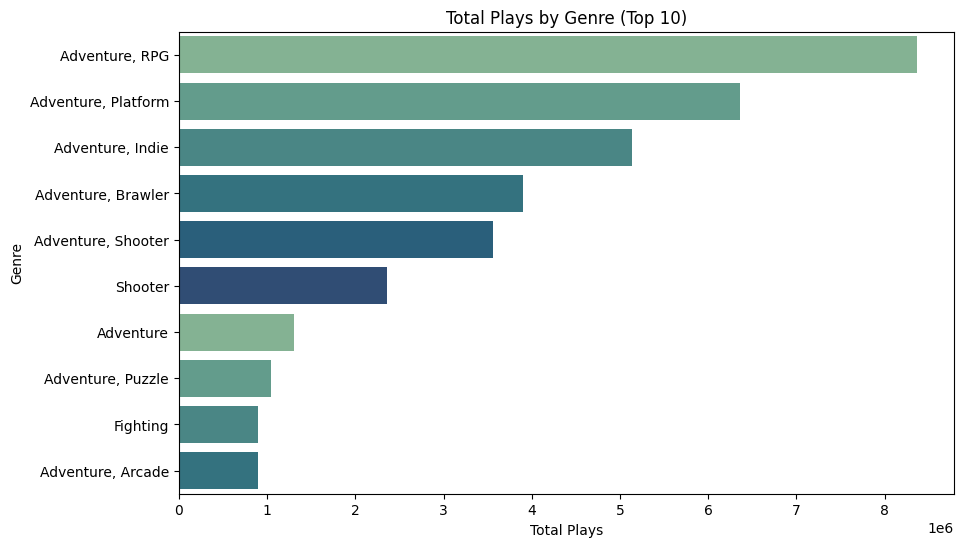

In [ ]:
# Top 10 generos más jugados
genre_plays = df.groupby('Genres')['Plays'].sum().reset_index()
genre_plays = genre_plays.sort_values(by='Plays', ascending=False)
top_10_genres = genre_plays.head(10)

plt.figure(figsize=(10, 6))
sns.barplot(x='Plays', y='Genres', data=top_10_genres,palette=sns.color_palette("crest"))
plt.title('Total Plays by Genre (Top 10)')
plt.xlabel('Total Plays')
plt.ylabel('Genre')
plt.show()


Del gráfico 'Total plays by genre' se puede ver que el género de mayor popularidad corresponde al de “Aventuras” (Adventure), dado que en los puestos más altos se tiene este género, acompañado de los generos ‘RPG’, ‘Plataforma’ y ‘Disparos’ en los primeros tres lugares de popularidad.


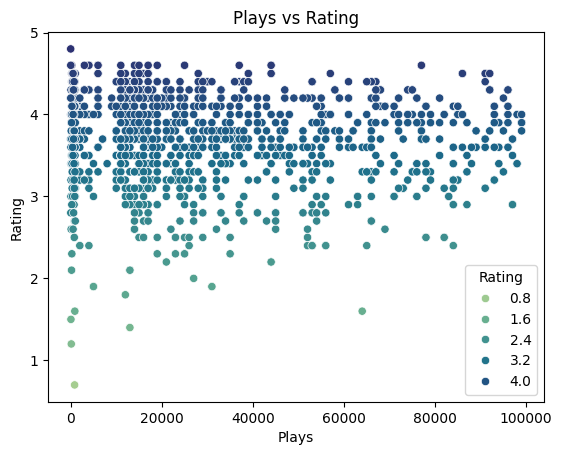

In [ ]:
# Gráfico de dispersión para jugadas vs rating
sns.scatterplot(x='Plays', y='Rating', hue='Rating', data=df, palette=sns.color_palette("crest", as_cmap=True))
plt.title('Plays vs Rating')
plt.xlabel('Plays')
plt.ylabel('Rating')
plt.show()


Del gráfico 'Plays vs Rating' se puede ver que los juegos con menor cantidad de usuarios muestran calificaciones más variadas, del 1 al 5, mientras que los con más usuarios tienen las calificaciones más concentradas en el rango de 3 a 5.
Además, se observa la tendencia de que los juegos más populares tienden a tener calificaciones más altas, indicando que los juegos más populares son mejor recibidos por los usuarios.


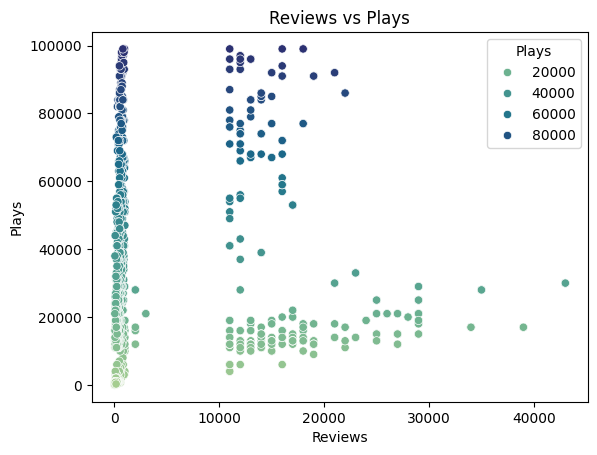

In [ ]:
# Gráfico de dispersión para reseñas vs jugadas
sns.scatterplot(x='Reviews', y='Plays', hue='Plays', data=df, palette=sns.color_palette("crest", as_cmap=True))
plt.title('Reviews vs Plays')
plt.xlabel('Reviews')
plt.ylabel('Plays')
plt.show()


Del gráfico 'Reviews vs Plays' se puede ver que hay una gran concentración de juegos con menos de 1000 reseñas, y estos juegos abarcan un amplio rango de jugadas, desde muy pocas hasta cerca de 100,000. Esto sugiere que muchos juegos reciben pocas reseñas independientemente de su popularidad en términos de jugadas.
Los juegos con más de 1,000 reseñas están dispersos y no muestran una tendencia clara en cuanto al número de jugadas. Algunos juegos con un número elevado de reseñas tienen muchas jugadas, mientras que otros tienen menos.


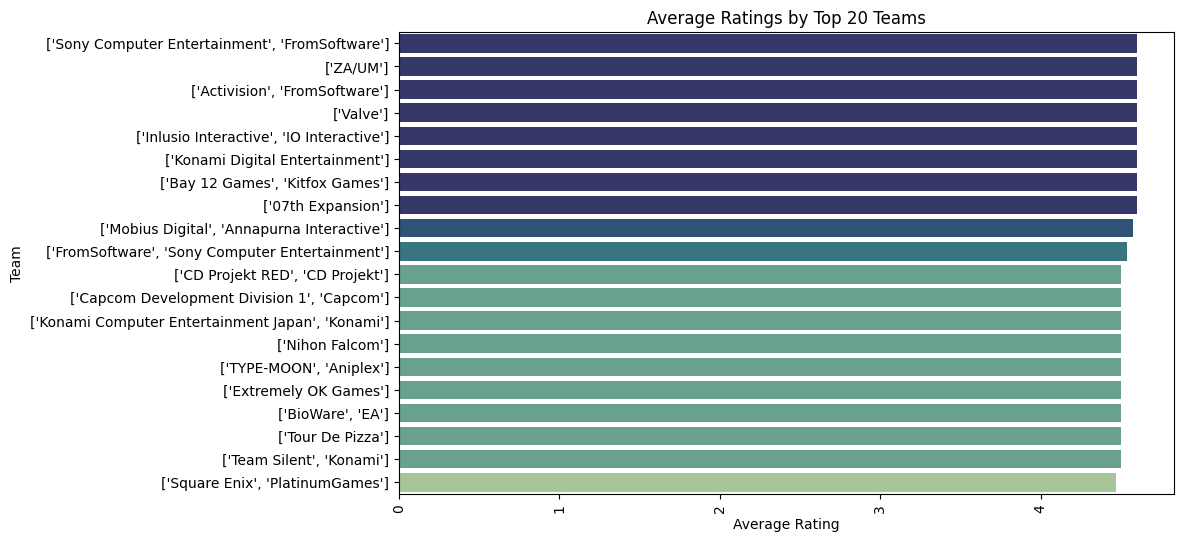

In [ ]:
# Top 20 equipos de desarrollo según el rating promedio
team_ratings = df.groupby('Team')['Rating'].mean().reset_index()
team_ratings = team_ratings.sort_values(by='Rating', ascending=False)
top_20_teams = team_ratings.head(20)

plt.figure(figsize=(10, 6))
sns.barplot(x='Rating', y='Team', data=top_20_teams, hue='Rating', palette=sns.color_palette("crest", as_cmap=True))
plt.title('Average Ratings by Top 20 Teams')
plt.xlabel('Average Rating')
plt.ylabel('Team')
plt.xticks(rotation=90)
plt.legend().remove()
plt.show()



Del gráfico 'Average Rating by Top 20 Teams' se puede ver que los equipos con las calificaciones promedio más altas tienen calificaciones cercanas a 4.5 o superiores. Esto indica que estos equipos consistentemente producen juegos de alta calidad según las calificaciones de los usuarios.
Equipos como "Sony Computer Entertainment" y "FromSoftware" aparecen múltiples veces, lo que sugiere una reputación consistente de alta calidad en sus juegos.


# Outliers

In [ ]:
# Se crea un boxplot para ver valores atipicos de columnas numericas
figrat = px.box(df, x='Rating', title='Rating')
figrat.update_xaxes(title_text='Rating')
figrat.update_layout(
    height=400,
    width=800
    )

figrat.show()

figrev = px.box(df, x='Reviews', title='Reviews')
figrev.update_xaxes(title_text='Reviews')
figrev.update_layout(
    height=400,
    width=800
    )

figrev.show()

figplay = px.box(df, x='Plays', title='Plays')
figplay.update_xaxes(title_text='Plays')
figplay.update_layout(
    height=400,
    width=800
    )

figplay.show()

figwish = px.box(df, x='Wishlist', title='Wishlist')
figwish.update_xaxes(title_text='Wishlist')
figwish.update_layout(
    height=400,
    width=800
    )

figwish.show()

Se observa que existen muchos datos que escapan al promedio de datos, pero estos se mantenienen de igual manera ya que generalmente los videojuegos con mejores calificaciones poseen mayor cantidad de reseñas y jugadas, por lo cual se tiene que corresponde a datos realistas y no son modificados para el estudio.

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1498 entries, 0 to 1497
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Title     1498 non-null   object 
 1   Release   1498 non-null   object 
 2   Team      1498 non-null   object 
 3   Rating    1498 non-null   float64
 4   Reviews   1498 non-null   int64  
 5   Genres    1498 non-null   object 
 6   Plays     1498 non-null   int64  
 7   Wishlist  1498 non-null   int64  
dtypes: float64(1), int64(3), object(4)
memory usage: 93.8+ KB


# Ingeniería de atributos

In [18]:
# Se limita la columna 'Team' a solo el primer estudio involucrado en la creación del videojuego, exceptuando el caso de 'FromSoftware'
def get_first_team(team_str):
    team_list = ast.literal_eval(team_str)
    if "FromSoftware" in team_list:
        return "FromSoftware"
    return team_list[0]

df['Team'] = df['Team'].apply(get_first_team)

df.head()

,Title,Release,Team,Rating,Reviews,Genres,Plays,Wishlist
0,Elden Ring,"Feb 25, 2022",FromSoftware,4.5,39000,"Adventure, RPG",17000,48000
1,Hades,"Dec 10, 2019",Supergiant Games,4.3,29000,"Adventure, Brawler",21000,36000
2,The Legend of Zelda: Breath of the Wild,"Mar 03, 2017",Nintendo,4.4,43000,"Adventure, RPG",30000,26000
3,Undertale,"Sep 15, 2015",tobyfox,4.2,35000,"Adventure, Indie",28000,18000
4,Hollow Knight,"Feb 24, 2017",Team Cherry,4.4,3000,"Adventure, Indie",21000,23000


# Preprocesamiento de datos

In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1498 entries, 0 to 1497
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Title     1498 non-null   object 
 1   Release   1498 non-null   object 
 2   Team      1498 non-null   object 
 3   Rating    1498 non-null   float64
 4   Reviews   1498 non-null   int64  
 5   Genres    1498 non-null   object 
 6   Plays     1498 non-null   int64  
 7   Wishlist  1498 non-null   int64  
dtypes: float64(1), int64(3), object(4)
memory usage: 93.8+ KB


### Codificación de variables categoricas

In [20]:
# Se crea una copia del df para modelar
df_model = df.copy()

In [21]:
df_model.columns

Index(['Title', 'Release', 'Team', 'Rating', 'Reviews', 'Genres', 'Plays',
       'Wishlist'],
      dtype='object')

In [22]:
# Se pasan los datos a valores numericos usando LabelEncoder
column=['Team','Genres']
df_model[column] = df_model[column].apply(LabelEncoder().fit_transform)

In [23]:
df_model

,Title,Release,Team,Rating,Reviews,Genres,Plays,Wishlist
0,Elden Ring,"Feb 25, 2022",132,4.5,39000,11,17000,48000
1,Hades,"Dec 10, 2019",376,4.3,29000,3,21000,36000
2,The Legend of Zelda: Breath of the Wild,"Mar 03, 2017",262,4.4,43000,11,30000,26000
3,Undertale,"Sep 15, 2015",461,4.2,35000,6,28000,18000
4,Hollow Knight,"Feb 24, 2017",386,4.4,3000,6,21000,23000
...,...,...,...,...,...,...,...,...
1493,Back to the Future: The Game,"Dec 22, 2010",395,3.2,94,9,763,67
1494,Team Sonic Racing,"May 21, 2019",374,2.9,264,26,15000,107
1495,Dragon's Dogma,"May 22, 2012",61,3.7,210,32,11000,206
1496,Baldur's Gate 3,"Oct 06, 2020",204,4.1,165,11,269,602


In [24]:
# Se eliminan las columnas "Title" y "Release"
df_model.drop(['Title', 'Release'], axis=1, inplace=True)
df_model.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1498 entries, 0 to 1497
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Team      1498 non-null   int64  
 1   Rating    1498 non-null   float64
 2   Reviews   1498 non-null   int64  
 3   Genres    1498 non-null   int64  
 4   Plays     1498 non-null   int64  
 5   Wishlist  1498 non-null   int64  
dtypes: float64(1), int64(5)
memory usage: 70.3 KB


# Feature Selection

In [25]:
# Se deja como variable objetiva la columna 'Rating'
X = df_model.drop(['Rating'],axis=1)
y = df_model['Rating']

In [26]:
X.head()

,Team,Reviews,Genres,Plays,Wishlist
0,132,39000,11,17000,48000
1,376,29000,3,21000,36000
2,262,43000,11,30000,26000
3,461,35000,6,28000,18000
4,386,3000,6,21000,23000


In [27]:
y

,Rating
0,4.5
1,4.3
2,4.4
3,4.2
4,4.4
...,...
1493,3.2
1494,2.9
1495,3.7
1496,4.1


# Lazy Predict

Se utiliza Lazy Predict para ver los mejores modelos

In [28]:
from lazypredict.Supervised import LazyRegressor
from sklearn.model_selection import train_test_split


In [29]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [30]:
reg = LazyRegressor(verbose=0, ignore_warnings=True, custom_metric=None)
models, predictions = reg.fit(X_train, X_test, y_train, y_test)
print(models)


100%|██████████| 42/42 [00:10<00:00,  4.17it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000253 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 862
[LightGBM] [Info] Number of data points in the train set: 1198, number of used features: 5
[LightGBM] [Info] Start training from score 3.716694
                               Adjusted R-Squared  R-Squared  RMSE  Time Taken
Model                                                                         
ExtraTreesRegressor                          0.55       0.56  0.35        0.87
RandomForestRegressor                        0.53       0.54  0.36        0.88
BaggingRegressor                             0.45       0.46  0.39        0.17
HistGradientBoostingRegressor                0.45       0.46  0.39        0.94
LGBMRegressor                                0.45       0.46  0.39        0.12
XGBRegressor                                 0.42       0.43  0.40        0.33
GradientBoostingRegressor    

Basandose en los valores obtenidos de Lazy Predict se tiene que los mejores modelos corresponden a ExtraTreesRegressor y RandomForestRegressor, pero por los conocimientos actuales se utilizarán para el estudio los modelos RandomForestRegressor y LGBMRegressor.

# Modelos

## RandomForestRegressor

In [31]:
# Se entrena el modelo
model = RandomForestRegressor(random_state=42)
model.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [32]:
# Se evalua el modelo
y_pred = model.predict(X_test)

In [33]:
# Calcular RMSE y R2
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f'RMSE: {rmse:.2f}')
print(f'R²: {r2:.2f}')

RMSE: 0.36
R²: 0.54


## LGBMRegressor

In [34]:
# Se entrena el modelo
model = LGBMRegressor(random_state=42)
model.fit(X_train, y_train)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000084 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 923
[LightGBM] [Info] Number of data points in the train set: 1198, number of used features: 5
[LightGBM] [Info] Start training from score 3.716694


LGBMRegressor(random_state=42)

In [35]:
# Se evalua
y_pred = model.predict(X_test)

In [36]:
# Calcular RMSE y R2
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f'RMSE: {rmse:.2f}')
print(f'R²: {r2:.2f}')

RMSE: 0.38
R²: 0.48


# Validación cruzada

## K-Fold Cross Validation

In [37]:
# Se establecen los valores para K-Fold
k = 5
kf = KFold(n_splits=k, shuffle=True, random_state=42)

# Se eligen los modelos usados
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
lgb_model = LGBMRegressor(n_estimators=100, random_state=42)

In [38]:
# Se calcula RMSE y R2 para RandomForest
rf_rmse_scores = cross_val_score(rf_model, X, y, cv=kf, scoring='neg_root_mean_squared_error')
rf_r2_scores = cross_val_score(rf_model, X, y, cv=kf, scoring='r2')

print(f'RandomForest RMSE: {-np.mean(rf_rmse_scores):.2f}')
print(f'RandomForest R²: {np.mean(rf_r2_scores):.2f}')


RandomForest RMSE: 0.38
RandomForest R²: 0.48


In [39]:
# Se calcula RMSE y R2 para LGBM
lgb_rmse_scores = cross_val_score(lgb_model, X, y, cv=kf, scoring='neg_root_mean_squared_error')
lgb_r2_scores = cross_val_score(lgb_model, X, y, cv=kf, scoring='r2')

print(f'LGBoost RMSE: {-np.mean(lgb_rmse_scores):.2f}')
print(f'LGBoost R²: {np.mean(lgb_r2_scores):.2f}')



[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000127 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 923
[LightGBM] [Info] Number of data points in the train set: 1198, number of used features: 5
[LightGBM] [Info] Start training from score 3.716694
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000081 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 923
[LightGBM] [Info] Number of data points in the train set: 1198, number of used features: 5
[LightGBM] [Info] Start training from score 3.732721
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000082 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 928
[LightGBM] [Info] Number of data points in the train set: 1198, number of used features: 5
[LightGBM] [Info] Start training fro

# Optimización

## Randomized Search

In [ ]:
# Se establecen los valores para randomized
param_dist_rf = {
    'n_estimators': [100, 200, 500],
    'max_depth': [10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}
rf_random_search = RandomizedSearchCV(estimator=RandomForestRegressor(),
                                      param_distributions=param_dist_rf,
                                      n_iter=100, cv=5, random_state=42)
rf_random_search.fit(X_train, y_train)

RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(), n_iter=100,
                   param_distributions={'max_depth': [10, 20, 30],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [100, 200, 500]},
                   random_state=42)

In [ ]:
# Se ajustan los parametros para evitar exceso de alertas
lgbm = LGBMRegressor(verbosity=-1)

param_dist_lgbm = {
    'num_leaves': [31, 50, 100],
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [100, 200, 500],
    'min_gain_to_split': [0.0, 0.1, 0.2]
}

lgbm_random_search = RandomizedSearchCV(estimator=lgbm,
                                        param_distributions=param_dist_lgbm,
                                        n_iter=100, cv=5, random_state=42)
lgbm_random_search.fit(X_train, y_train)

RandomizedSearchCV(cv=5, estimator=LGBMRegressor(verbosity=-1), n_iter=100,
                   param_distributions={'learning_rate': [0.01, 0.05, 0.1],
                                        'min_gain_to_split': [0.0, 0.1, 0.2],
                                        'n_estimators': [100, 200, 500],
                                        'num_leaves': [31, 50, 100]},
                   random_state=42)

In [ ]:
best_rf_model = rf_random_search.best_estimator_
best_lgbm_model = lgbm_random_search.best_estimator_

In [ ]:
# Rendimiento RandomForest
y_pred_rf = best_rf_model.predict(X_test)
mse_rf = mean_squared_error(y_test, y_pred_rf)
rmse_rf = np.sqrt(mse_rf)
r2_rf = r2_score(y_test, y_pred_rf)

print(f"RMSE: {rmse_rf:.2f}")
print(f"R²: {r2_rf:.2f}")

RMSE: 0.36
R²: 0.54


In [ ]:
# Rendimiento LightGBM
y_pred_lgbm = best_lgbm_model.predict(X_test)
mse_lgbm = mean_squared_error(y_test, y_pred_lgbm)
rmse_lgbm = np.sqrt(mse_lgbm)
r2_lgbm = r2_score(y_test, y_pred_lgbm)

print(f"RMSE: {mse_lgbm:.2f}")
print(f"R²: {r2_lgbm:.2f}")

RMSE: 0.14
R²: 0.50


In [ ]:
# Se ven los mejores hiperparámetros para ambos modelos
print(f"Mejores hiperparámetros para RandomForest: {rf_random_search.best_params_}")
print(f"Mejores hiperparámetros para LightGBM: {lgbm_random_search.best_params_}")


Mejores hiperparámetros para RandomForest: {'n_estimators': 500, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': 20}
Mejores hiperparámetros para LightGBM: {'num_leaves': 50, 'n_estimators': 100, 'min_gain_to_split': 0.0, 'learning_rate': 0.1}


# Resultados

Se observa que los modelos RandomForestRegressor (RF) y LGBMRegressor (LGBM) son dos de los modelos que mejor resultados dan según LazyPredict, esto es apreciable también al ejecutar cada uno por separado. Se observa que en estos modelos se tiene para RF un RMSE=0.36 y un R²=0.54, mientras que para LGBM se tiene un RMSE=0.38 y un R²=0.48. Con lo cual se tiene que RandomForest tiene mejores resultados con respecto a LGBM, ya que ofrece predicciones más precisas.

Con respecto a la validación cruzada se aplicó el metodo K-Fold, con el que se tienen que los valores para RF son RMSE=0.38 y R²=0.48 y para LGBM de RMSE=0.40 y R²=0.42. Ambos modelos muestran un rendimiento ligeramente inferior en la validación cruzada en comparación con sus rendimientos iniciales (modelos base). Esto sugiere que los modelos base podrían haber estado un poco sobreajustados a los datos de entrenamiento iniciales.

Finalmente, en cuanto a la optimización, se utilizó el metodo Randomized Search para ambos modelos con los que se obtuvo que para RF se tiene un RMSE=0.36 y un R²=0.54, mientras que para LGBM se tiene un RMSE=0.14 y un R²=0.50. Se observa que RandomForest tuvo un rendimiento estable a lo largo de los análisis, con un RMSE de 0.36 y un R² de 0.54 tanto en los modelos base como después de la optimización con Randomized Search.

# Conclusiones


Insights:
* Los juegos con mayor cantidad de veces jugados tienden a ser mejor calificados.
* La calidad de los juegos es percibida de manera diversa, especialmente entre aquellos con menos jugadas.
* La cantidad de reseñas no siempre refleja la popularidad del juego, lo que indica que esta es influenciada por otros factores.
* Algunos desarrolladores tienen una reputación constante de alta calidad, tanto en estudios grandes como independientes.

En conclusión, se tiene una relación entre la calidad percibida por los usuarios y la popularidad de los juegos. Los juegos más jugados generalmente reciben calificaciones más altas, lo que indica que los jugadores suelen dedicar más tiempo a los juegos que consideran de alta calidad. Pese a esto, es importante destacar que la percepción de la calidad entre los usuarios varía significativamente. Esta diversidad es particularmente evidente en los juegos con menos jugadas, donde se pueden tener calificaciones más variables debido a los gustos y experiencias de los jugadores.

Además, aunque la popularidad y la calidad están relacionadas, los gustos son subjetivos, lo que puede llegar a afectar la popularidad de un videojuego según como lo aprecie el usuario. Los desarrolladores que entregan regularmente juegos de alta calidad pueden lograr mayores ventas al sacar nuevos titulos, debido a que los usuarios confían en que estos serán de la calidad esperada. Esto demuestra la importancia de comprender las diversas expectativas de los jugadores y mantener altos estándares de calidad para lograr el éxito a largo plazo en el sector de los videojuegos.

Se observa que la validación cruzada mostró una pequeña reducción en el rendimiento de RandomForest, lo que sugiere que el modelo es relativamente robusto y generaliza bien. Mientras que en el caso de LGBM se observa que aunque comenzó con un rendimiento ligeramente inferior, experimentó una mejora significativa después de la optimización, reduciendo su RMSE de 0.38 a 0.14. Esto indica que el modelo de LGBM es altamente sensible a la optimización de hiperparámetros y puede llegar a ser muy preciso. Sin embargo, su R² de 0.50, aunque cercano al de RandomForest, no logró superar su capacidad explicativa.
